## 1) Import packages

In [0]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier

from matplotlib import pyplot
from matplotlib.colors import ListedColormap

## 2) Prepare dataset

In [0]:
N = 1000
train_split = 0.7

# Generate dataset
X, y = make_classification(n_samples=N, n_classes=2, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, flip_y = 0.01) 

#X = StandardScaler().fit_transform(X)
#X = MinMaxScaler().fit_transform(X)

# Split 70/30
train_N = int(N * train_split)
train_X = X[:train_N,:].copy()
train_Y = y[:train_N].copy()
test_X = X[train_N:,:].copy()
test_Y = y[train_N:].copy()

#y = [(1 if item > 0 else -1) for item in y]

## Plotting functions

In [0]:
def show_scatter_plot(x,y,x_axis_label,y_axis_label,plot_title):
    pyplot.figure()
    pyplot.plot(x,y,'r-')
    pyplot.xlabel(x_axis_label)
    pyplot.ylabel(y_axis_label)
    pyplot.title(plot_title)
    pyplot.show()

In [0]:
def plot_decision_boundary(predict, X, y, N = 10, scatter_weights = np.ones(len(y))):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    
    zz = np.array([predict(np.array([xi,yi]).reshape(1,-1)) for xi, yi in zip(np.ravel(xx), np.ravel(yy))])            
    # reshape result and plot
    Z = zz.reshape(xx.shape)

    ax = pyplot.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c = y, cmap = ListedColormap(['#FF0000', '#0000FF']), s = scatter_weights * 20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

## 3) Exercise 1. Neural network

### Classes

In [0]:
class NeuronLayer():
    """A layer of neurons class.
    
    Parameters
    ----------
    n_neurons : int
        Number of neurons on the layer. 
    n_inputs : int    
        Number of inputs per neuron.

    Attributes
    ----------
    weights : array, shape (n_inputs, n_neurons)
        Synaptic weights of the input signals

    """
    
    def __init__(self, n_neurons, n_inputs):
        self.weights = 2 * np.random.random((n_inputs, n_neurons)) - 1
        
    def __str__(self):
        message = "%d neurons with %d inputs" % (self.weights.shape[1], self.weights.shape[0])
        message += "\nWeights: \n" 
        message += str(self.weights)
        return message

In [0]:
class LogSigmoid():
    """Logistic sigmoid (logsig) activation function."""
  
    @staticmethod
    def function(x):
        """Function.
        
        Parameters
        ----------
        x : array
            Input.
            
        Returns
        ----------
        Value of the function.
        
        """
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def derivative(x):
        """Derivative of the function.
        
        Parameters
        ----------
        x : array
            Input.
            
        Returns
        ----------
        Derivative of the function.
        
        """
        x = np.asarray(x)
        return x * (1 - x)

In [0]:
class NeuralNetwork():
    """A neural network class.
    
    Parameters
    ----------
    layers : array
        Layers of the neural network. 
        
    activation_func : string
        Name of the activation function

    Attributes
    ----------
    _activation_func : function
        Activation function.
    
    layers : array
        Layers of the neural network.

    """  
  
    def __init__(self, layers, activation_func = "logsig"):
        self.layers = layers
        self._activation_func = activation_func
        
    def __str__(self):
        message = ""
        for i, layer in enumerate(self.layers):
            message += str("\nLayer %d \n" % (i+1))
            message += str(layer)
            message += "\n----------"
        return message 
   
    @property
    def activation(self):
        if self._activation_func == "logsig":
            return LogSigmoid()
          
    def train(self, train_x, train_y, n_epoch):
        """Train neural network.
    
        Parameters
        ----------
        train_x : ndarray    
            Training set of input signals.
            
        train_y : array    
            Training set of output signals.
            
        n_epoch : int
            Number of iterations.
    
        """       
        actual = train_y
        n_layers = len(self.layers)
        
        for epoch in range(n_epoch):
            
            # Pass the training set through the neural network
            [hidden_state_1, hidden_state_2, predicted] = self.predict(train_x)
            
            # Calculate loss functions
            layer3_error = np.asarray(actual - predicted).T
            layer3_delta = np.asarray(layer3_error.T * self.activation.derivative(predicted)).T
            
            layer2_error = np.asarray(layer3_delta.dot(self.layers[-1].weights.T))
            layer2_delta = np.asarray(layer2_error.T * self.activation.derivative(hidden_state_2)).T

            layer1_error = np.asarray(layer2_delta.dot(self.layers[-2].weights.T))
            layer1_delta = np.asarray(layer1_error.T * self.activation.derivative(hidden_state_1)).T
                       
            layer_errors = [layer1_error, layer2_error, layer3_error]
            layer_deltas = [layer1_delta, layer2_delta, layer3_delta]
            
            # Adjust the weights.
            self.layers[0].weights += train_x.T.dot(layer1_delta)
            self.layers[1].weights += np.asarray(hidden_state_1).dot(layer2_delta)
            self.layers[2].weights += np.asarray(hidden_state_2).dot(layer3_delta)

    
    def predict(self, inputs):
        """Predict (calculate output for each layer)
    
        Parameters
        ----------
        inputs : array    
            Input signals.
        
        Returns
        -------
        outputs : array
            Outputs for each layer, last item in the array is the prediction.
    
        """
        
        x = np.asarray(inputs.copy())
        layers_outputs = list()
        
        for layer in self.layers:
            outputs = list() 
            
            for i in range(layer.weights.shape[1]):
                neuron_weights = layer.weights[:,i]
                wx = np.dot(x, neuron_weights)
                y = self.activation.function(wx)
                outputs.append(y)
                
            layers_outputs.append(outputs.copy())
            
        return layers_outputs

### Test performance

Number of epochs: 100
Step 1. Initialize a neural network with random weights: 

Layer 1 
2 neurons with 2 inputs
Weights: 
[[-0.1280102  -0.94814754]
 [ 0.09932496 -0.12935521]]
----------
Layer 2 
2 neurons with 2 inputs
Weights: 
[[-0.1592644  -0.33933036]
 [-0.59070273  0.23854193]]
----------
Layer 3 
1 neurons with 2 inputs
Weights: 
[[-0.40069065]
 [-0.46634545]]
----------
Step 2. Train the neural network.
New weights after training: 

Layer 1 
2 neurons with 2 inputs
Weights: 
[[-18.65799512 -19.79313321]
 [-29.76946014 -30.30108593]]
----------
Layer 2 
2 neurons with 2 inputs
Weights: 
[[34.81663214 29.54094283]
 [35.40621367 30.62984281]]
----------
Layer 3 
1 neurons with 2 inputs
Weights: 
[[37.34830788]
 [28.20760808]]
----------
Step 3. Test the neural network.
Accuracy: 0.3466666666666667
Number of epochs: 200
Step 1. Initialize a neural network with random weights: 

Layer 1 
2 neurons with 2 inputs
Weights: 
[[-18.65799512 -19.79313321]
 [-29.76946014 -30.30108593]]


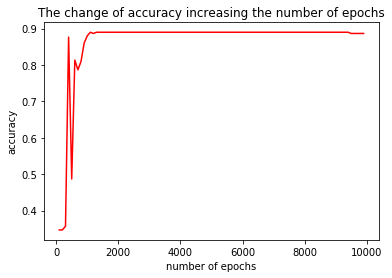

In [212]:
#Seed the random number generator
np.random.seed(2)

training_set_inputs = train_X.copy()
training_set_outputs = train_Y.copy()

n_inputs = training_set_inputs.shape[1]
n_neurons_layer1 = 2
n_neurons_layer2 = 2

# Create neuron layers
hidden_layer1 = NeuronLayer(n_neurons_layer1, n_inputs)
hidden_layer2 = NeuronLayer(n_neurons_layer2, n_neurons_layer1)
output_layer = NeuronLayer(1, n_neurons_layer2)

layers = [hidden_layer1, hidden_layer2, output_layer]

# Create a neural network
neural_network = NeuralNetwork(layers)

accuracies = list()
for j in range(100,10000,100):
    print("Number of epochs: %d" % j)
    
    print("Step 1. Initialize a neural network with random weights: ")
    print(str(neural_network))

    print("Step 2. Train the neural network.")
    neural_network.train(training_set_inputs, training_set_outputs, j)
    print("New weights after training: ")
    print(str(neural_network))

    print ("Step 3. Test the neural network.")
    testing_set_inputs = test_X.copy()
    testing_set_outputs = test_Y.copy()  
    
    predicted = list()
        
    for i in range(testing_set_inputs.shape[0]):
        
        test = np.reshape(testing_set_inputs[i, :], (1, len(testing_set_inputs[i, :])))
  
        hidden_state1, hidden_state2, output = neural_network.predict(test)
        output = np.reshape(output, 1)[0]
        output = int(round(output))
        predicted.append(output)
    
    accuracy = sum(testing_set_outputs == predicted) / len(predicted)
        
    print("Accuracy: " + str(accuracy))
        
    accuracies.append(accuracy)
         
print(accuracies)
show_scatter_plot(list(range(100,10000,100)),accuracies,"number of epochs","accuracy","The change of accuracy increasing the number of epochs")

## 4) AdaBoost

### Class

In [0]:
class CustomAdaBoostClassifier():
    """AdaBoost classifier.
   
    Parameters
    ----------
    n_estimators : integer, optional (default=10)
        The maximum number of estimators at which boosting is terminated.
            
    Attributes
    ----------
    estimators : list of classifiers
        The collection of fitted sub-estimators.
    estimator_weights : array of floats
        Weights for each estimator in the boosted ensemble.
    estimator_errors : array of floats
        Classification error for each estimator in the boosted ensemble.
    
    """
    def __init__(self, n_estimators=10):
            self.n_estimators=n_estimators
          
            self.estimators = list()
            self.estimator_weights = list()
            self.estimator_errors = list()
            self.sample_weights = list()
        
    def _init_weights(self, N):
        return np.ones(N, dtype=np.float64) / N
      
    def _boost(self, X, y, sample_weight):
        """Implement a single boost.
        Perform a single boost and return the updated sample weights.
        
        Parameters
        ----------
        X : 2d array, shape = [n_samples, n_features]
            The training input samples.
        y : array, shape = [n_samples]
            The target values (class labels).
        sample_weight : array, shape = [n_samples]
            The current sample weights.
            
        Returns
        -------
        sample_weight : array, shape = [n_samples] or None
            The reweighted sample weights.
        estimator_weight : float
            The weight for the current boost.
        estimator_error : float
            The classification error for the current boost.
        estimator : classifier
            Adjusted weak classifier.
        y_predict : array
            Predictions of training data.
        """
        
        estimator = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Instances incorrectly classified
        incorrect = y_predict != y

        # Compute the weighted error
        estimator_error = np.mean(
            np.average(incorrect, weights=sample_weight, axis=0))

        # Stop if classification is perfect
        if estimator_error <= 0:
            return sample_weight, 1., 0., estimator, y_predict

        # Compute coefficient
        alpha = 1 * np.log((1. - estimator_error) / estimator_error)

        # Set data weight 
        sample_weight *= np.exp(alpha * incorrect) * ((sample_weight > 0) | (alpha < 0))
        
        estimator_weight = alpha
              
        return sample_weight, estimator_weight, estimator_error, estimator, y_predict


    def fit(self, X, y, sample_weight=None):
        """Build a boosted classifier from the training set (X, y).
        
        Parameters
        ----------
        X : shape = [n_samples, n_features]
            The training input samples. 
        y : shape = [n_samples]
            The target values (class labels).
        sample_weight : shape = [n_samples], optional
            Sample weights.
        """

        if sample_weight == None: 
            # Initialize weights to 1 / n_samples
            sample_weight = self._init_weights(X.shape[0])
            
        for _ in range(self.n_estimators):

            # Boosting step
            sample_weight, estimator_weight, estimator_error, estimator, prediction = self._boost(
                X, y,
                sample_weight)
            
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight.copy())
            self.estimator_errors.append(estimator_error.copy())
            self.sample_weights.append(sample_weight.copy())
            #self.predictions.append(prediction)
   
        self.estimator_weights = np.asarray(self.estimator_weights)
        self.estimator_errors = np.asarray(self.estimator_errors)  
        self.sample_weights = np.asarray(self.sample_weights)
      
    def predict(self, X):
        """Predict classes for X.
        
        Parameters
        ----------
        X : 2darray, shape = [n_samples, n_features]
            The training input samples. 
        Returns
        -------
        Y : array, shape = [n_samples]
            The predicted classes.
        """
        Y = list()
        for i in range(X.shape[0]):
            x = X[i,:].reshape(1, -1)
            y = np.asarray([(estimator.predict(x)).T * weight for estimator, weight in zip(self.estimators, self.estimator_weights)])
            y = np.sign(y.sum(axis = 0))
            Y.append(int(y[0]))
        return Y

### Test performance

In [214]:
y = [(1 if item > 0 else -1) for item in y]

train_Y = y[:train_N].copy()
test_Y = y[train_N:].copy()

adaboost = CustomAdaBoostClassifier()
adaboost.fit(train_X,train_Y)

predicted = adaboost.predict(test_X)

flags = [1 if predicted[i] == test_Y[i] else 0 for i in range(len(predicted))]
accuracy = sum(flags) / len(predicted)  
print("Accuracy: " + str(accuracy))

Accuracy: 0.8966666666666666


[2.18145138 0.39559435 0.59323308 0.62840853 0.48600756 0.42329803
 0.44841298 0.33547393 0.38215002 0.35845333]


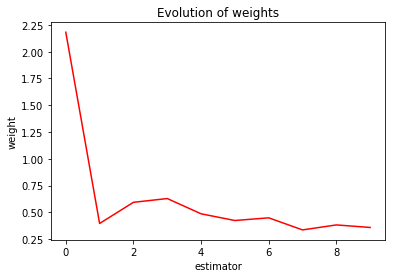

In [215]:
print(adaboost.estimator_weights)

show_scatter_plot(list(range(len(adaboost.estimator_weights))),adaboost.estimator_weights,"estimator","weight","Evolution of weights")

[0.10142857 0.4023713  0.35589338 0.34787149 0.38083453 0.39572783
 0.38973816 0.41690933 0.40560844 0.41133402]


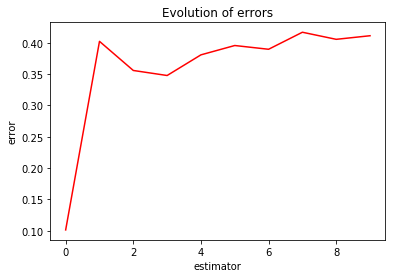

In [216]:
print(adaboost.estimator_errors)

show_scatter_plot(list(range(len(adaboost.estimator_errors))),adaboost.estimator_errors,"estimator","error","Evolution of errors")

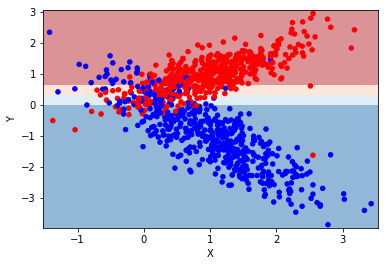

In [217]:
plot_decision_boundary(adaboost.predict, X, y)

Accuracy: 0.8966666666666666
Decision boundaries


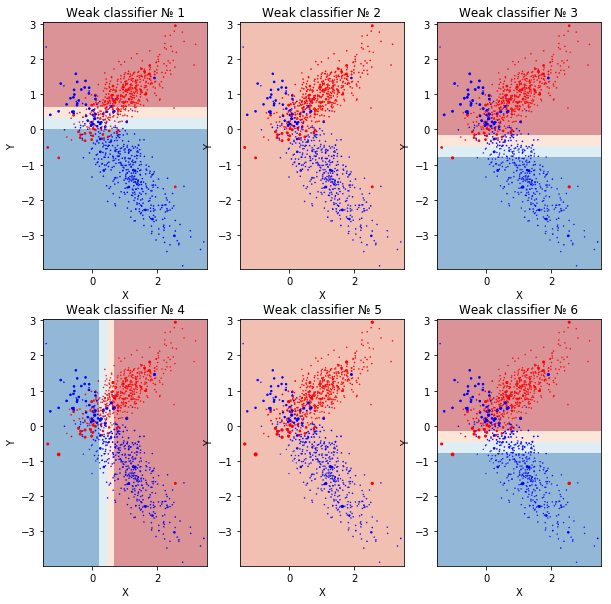

In [218]:
y = [(1 if item > 0 else -1) for item in y]

train_Y = y[:train_N].copy()
test_Y = y[train_N:].copy()

adaboost = CustomAdaBoostClassifier(n_estimators=6)
adaboost.fit(train_X,train_Y)

predicted = adaboost.predict(test_X)

flags = [1 if predicted[i] == test_Y[i] else 0 for i in range(len(predicted))]
accuracy = sum(flags) / len(predicted)  
print("Accuracy: " + str(accuracy))

print("Decision boundaries")
fig = pyplot.figure(figsize = (10,10))
for m in range(6):
    fig.add_subplot(2,3,m+1)
    s_weights = (adaboost.sample_weights[m,:] / adaboost.sample_weights[m,:].sum()) * 20
    plot_decision_boundary(adaboost.estimators[m].predict, X, y, scatter_weights = s_weights)
    pyplot.title('Weak classifier № {}'.format(m+1))

Accuracy: 0.8966666666666666
Accuracy: 0.8966666666666666
Accuracy: 0.8766666666666667


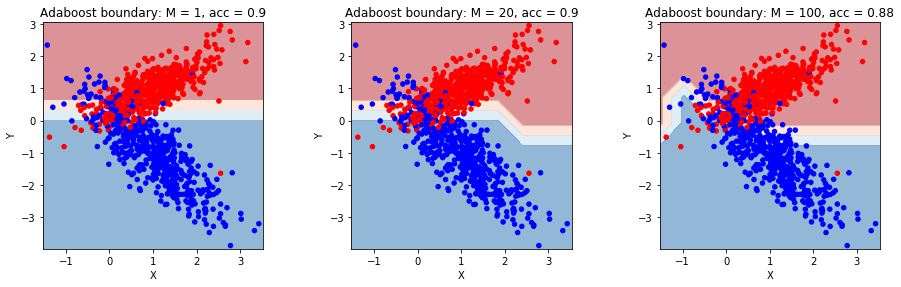

In [219]:
fig = pyplot.figure(figsize = (15,10))

for k,m in enumerate([1,20,100]):
    fig.add_subplot(2,3,k+1)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    adaboost = CustomAdaBoostClassifier(n_estimators=m)
    adaboost.fit(train_X,train_Y)
    predicted = adaboost.predict(test_X)

    flags = [1 if predicted[i] == test_Y[i] else 0 for i in range(len(predicted))]
    accuracy = sum(flags) / len(predicted)  
    print("Accuracy: " + str(accuracy))

    plot_decision_boundary(adaboost.predict, X, y)
    pyplot.title('Adaboost boundary: M = {}, acc = {}'.format(m, round(accuracy,2)))

Accuracy: 0.8966666666666666
Accuracy: 0.88
Accuracy: 0.8733333333333333


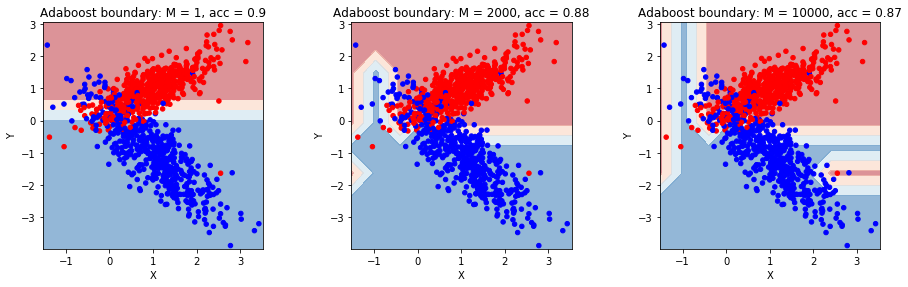

In [220]:
fig = pyplot.figure(figsize = (15,10))

for k,m in enumerate([1,2000,10000]):
    fig.add_subplot(2,3,k+1)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    adaboost = CustomAdaBoostClassifier(n_estimators=m)
    adaboost.fit(train_X,train_Y)
    predicted = adaboost.predict(test_X)

    flags = [1 if predicted[i] == test_Y[i] else 0 for i in range(len(predicted))]
    accuracy = sum(flags) / len(predicted)  
    print("Accuracy: " + str(accuracy))

    plot_decision_boundary(adaboost.predict, X, y)
    pyplot.title('Adaboost boundary: M = {}, acc = {}'.format(m, round(accuracy,2)))